In [3]:
import pandas as pd
import numpy as np

# library for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# library for analysis time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# library for forecasting
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

## Input Data

In [5]:
df = pd.read_excel("datasets/CO2 dataset.xlsx")

## Description of data

In [7]:
df.head()

,Year,CO2
0,1800,0.00568
1,1801,0.00561
2,1802,0.00555
3,1803,0.00548
4,1804,0.00542


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    215 non-null    int64  
 1   CO2     215 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.5 KB


## transform data

In [11]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

In [13]:
df.set_index(['Year'], inplace=True)

In [15]:
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [17]:
df.index.min(),df.index.max()

(Timestamp('1800-01-01 00:00:00'), Timestamp('2014-01-01 00:00:00'))

In [19]:
if(df.index.max() - df.index.min() == 240):
    print("Data is continuous")

In [21]:
df.index.freq = 'YS'

## Analysis Time Series

<Axes: xlabel='Year'>

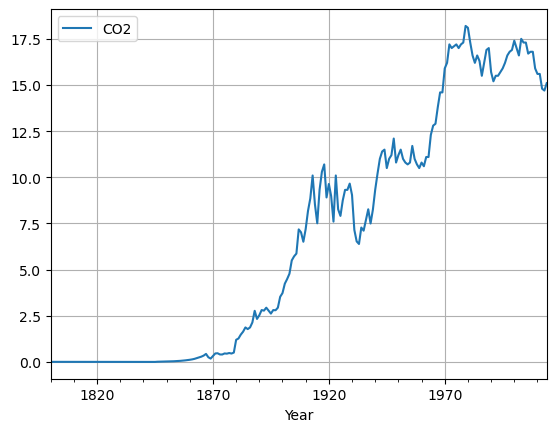

In [23]:
df.plot(grid=True)

In [25]:
train_df = df.loc[:'1991-01-01']
test_df = df.loc['1992-01-01':]

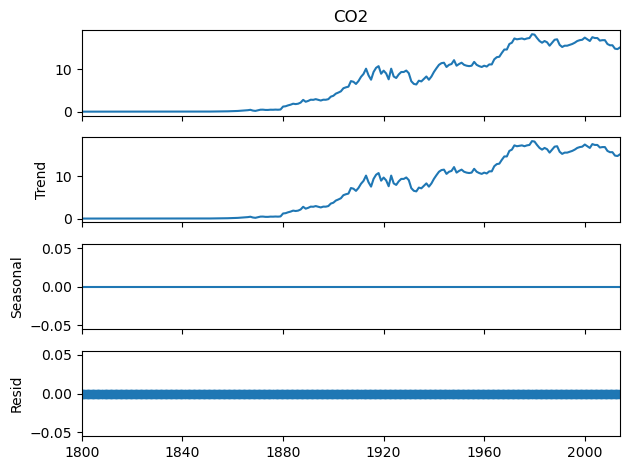

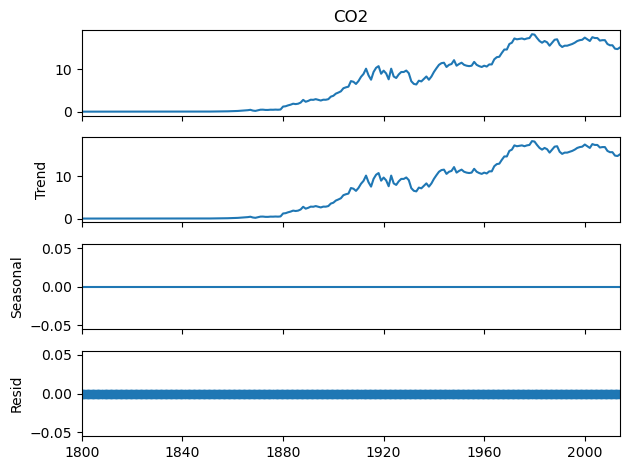

In [27]:
decompose_add = seasonal_decompose(df['CO2'])
decompose_add.plot()

In [29]:
def adf_test(timeseries):
    print('Result testing Dickey-Fuller')
    print('----------------------------')
    adftest = adfuller(timeseries)
    adf_output = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observation Used'])
    for key, Value in adftest[4].items():
        adf_output['Critical Value (%s)' %key] = Value
    print(adf_output)

adf_test(df.values)

Result testing Dickey-Fuller
----------------------------
Test Statistic                 -0.378463
p-value                         0.913633
Lags Used                       0.000000
Number of Observation Used    214.000000
Critical Value (1%)            -3.461282
Critical Value (5%)            -2.875143
Critical Value (10%)           -2.574020
dtype: float64


In [31]:
diff_df = df.diff()
diff_df.head()

,CO2
Year,
1800-01-01,NaN
1801-01-01,-0.00007
1802-01-01,-0.00006
1803-01-01,-0.00007
1804-01-01,-0.00006


In [33]:
diff_df.dropna(inplace=True)

<Axes: xlabel='Year'>

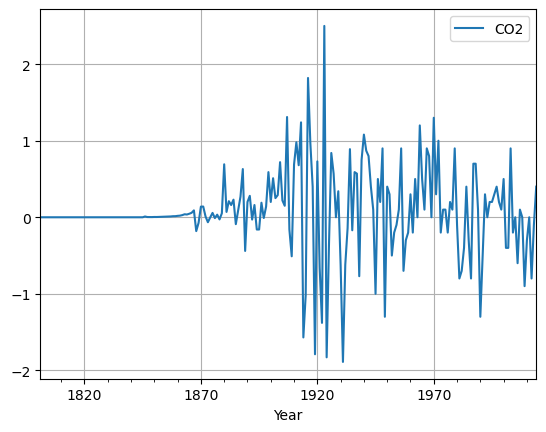

In [35]:
diff_df.plot(grid=True)

In [41]:
adf_test(diff_df)

Result testing Dickey-Fuller
----------------------------
Test Statistic                 -3.780005
p-value                         0.003119
Lags Used                      15.000000
Number of Observation Used    198.000000
Critical Value (1%)            -3.463815
Critical Value (5%)            -2.876251
Critical Value (10%)           -2.574611
dtype: float64


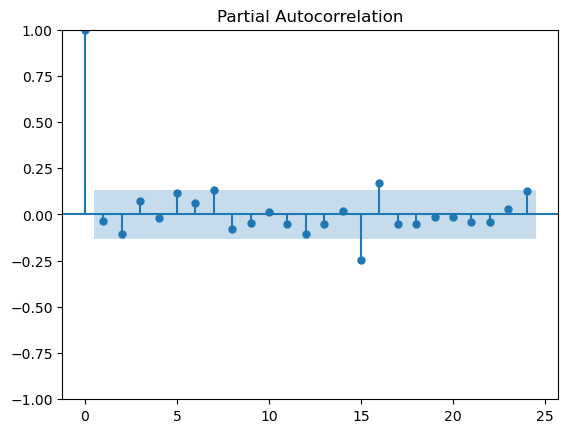

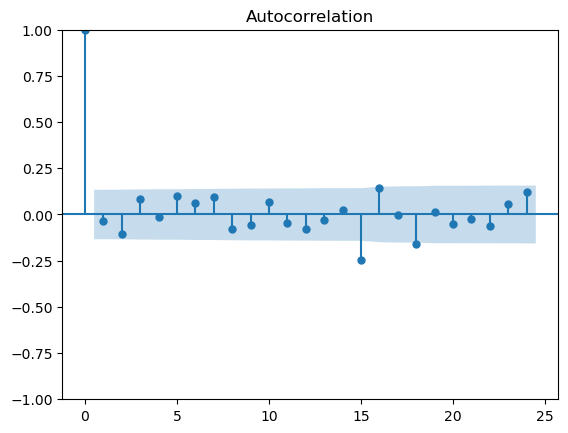

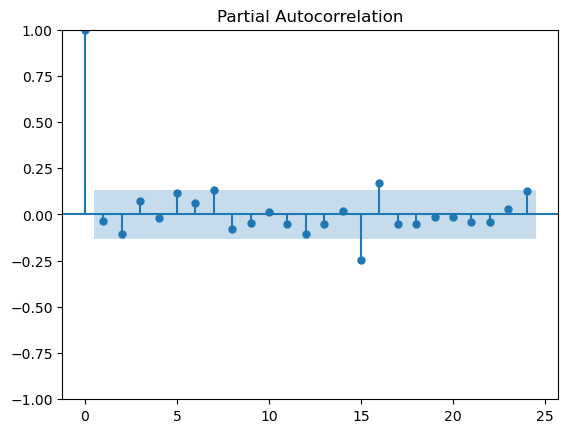

In [43]:
plot_acf(diff_df)
plot_pacf(diff_df)

## Single Exponential Smoothing

In [45]:
single_exp = SimpleExpSmoothing(train_df).fit()
single_exp_train_prediction = single_exp.fittedvalues
single_exp_test_prediction = single_exp.forecast(23)

<Axes: xlabel='Year'>

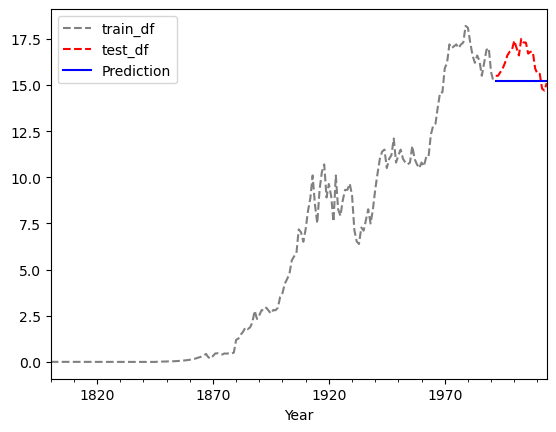

In [47]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
single_exp_test_prediction.plot(color='b',legend=True, label='Prediction')

In [55]:
print('Train RMSE: ', mean_squared_error(train_df, single_exp_train_prediction)**0.5)
print('Test RMSE: ', mean_squared_error(test_df, single_exp_test_prediction)**0.5)
print('Train MAPE:', mean_absolute_percentage_error(train_df, single_exp_train_prediction))
print('Test MAPE:', mean_absolute_percentage_error(test_df, single_exp_test_prediction))

Train RMSE:  0.564692002680021
Test RMSE:  1.3429113022690744
Train MAPE: 0.08470457297144988
Test MAPE: 0.06861466412071275


## Double Exponential Smoothing

In [61]:
double_exp = ExponentialSmoothing(train_df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=30, damped_trend=False).fit()
double_exp_train_prediction = double_exp.fittedvalues
double_exp_test_prediction = double_exp.forecast(23)

<Axes: xlabel='Year'>

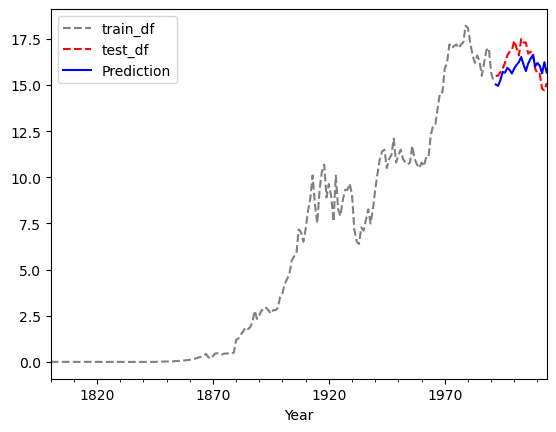

In [63]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
double_exp_test_prediction.plot(color='b',legend=True, label='Prediction')

In [65]:
print('Train RMSE: ', mean_squared_error(train_df, double_exp_train_prediction)**0.5)
print('Test RMSE: ', mean_squared_error(test_df, double_exp_test_prediction)**0.5)
print('Train MAPE:', mean_absolute_percentage_error(train_df, double_exp_train_prediction))
print('Test MAPE:', mean_absolute_percentage_error(test_df, double_exp_test_prediction))

Train RMSE:  0.5196296922095375
Test RMSE:  0.8471058706281209
Train MAPE: 19.75926459673781
Test MAPE: 0.04467873649812757


## ARIMA

In [67]:
ar = ARIMA(train_df, order=(15,1,15)).fit()
ar_train_prediction = ar.fittedvalues
ar_test_prediction = ar.forecast(23)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='Year'>

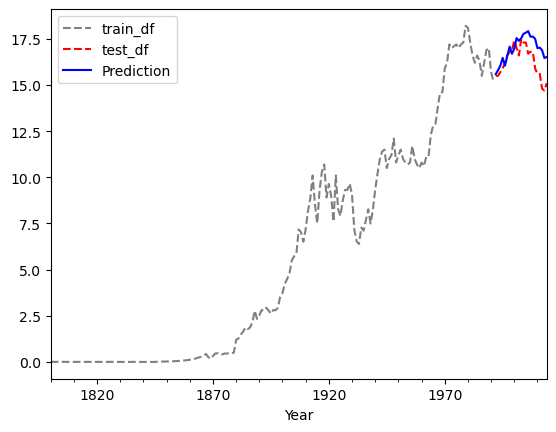

In [68]:
train_df['CO2'].plot(style='--', color='gray', legend=True, label='train_df')
test_df['CO2'].plot(style='--', color='r', legend=True, label='test_df')
ar_test_prediction.plot(color='b',legend=True, label='Prediction')

In [71]:
print('Train RMSE: ', mean_squared_error(train_df, ar_train_prediction)**0.5)
print('Test RMSE: ', mean_squared_error(test_df, ar_test_prediction)**0.5)
print('Train MAPE:', mean_absolute_percentage_error(train_df, ar_train_prediction))
print('Test MAPE:', mean_absolute_percentage_error(test_df, ar_test_prediction))

Train RMSE:  0.4678041742597004
Test RMSE:  0.9583019631569909
Train MAPE: 0.08140172292517174
Test MAPE: 0.04752572028923


## Comparison Algorithm

In [73]:
comparison_df = pd.DataFrame(data=[
    ['Single Exp Smoothing',1.3429, 0.06861 ],
    ['Double Exp Smoothing', 0.8471, 0.04467 ],
    ['ARIMA', 0.9583, 0.0475]
    ],
    columns=['Model','RMSE','MAPE'])
comparison_df.set_index('Model',inplace=True)

In [75]:
comparison_df.sort_values(by='RMSE')

,RMSE,MAPE
Model,,
Double Exp Smoothing,0.8471,0.04467
ARIMA,0.9583,0.04750
Single Exp Smoothing,1.3429,0.06861


In [89]:
ar = ARIMA(df, order=(15,1,15)).fit()
ar_prediction = ar.forecast(20)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


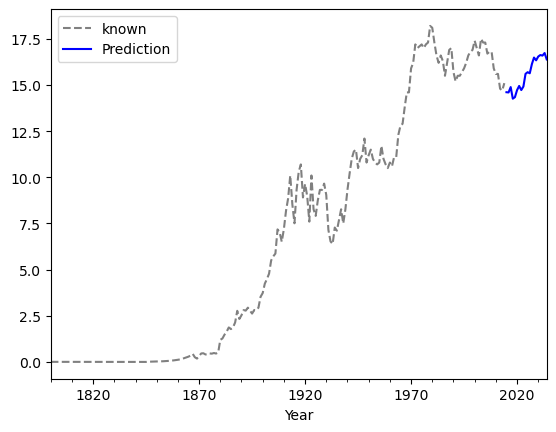

In [91]:
df['CO2'].plot(style='--', color='gray', legend=True, label='known')
ar_prediction.plot(color='b',legend=True, label='Prediction')
plt.show()

In [210]:
ar_prediction.dtypes

dtype('float64')

In [23]:
df.dtypes

CO2    float64
dtype: object

In [93]:
import pickle

In [95]:
pickle.dump(ar,open('c_prediction.sav','wb'))

In [77]:
double_exp = ExponentialSmoothing(df, trend=None, initialization_method='heuristic', seasonal='add', seasonal_periods=30, damped_trend=False).fit()
double_exp_pred = double_exp.forecast(23)

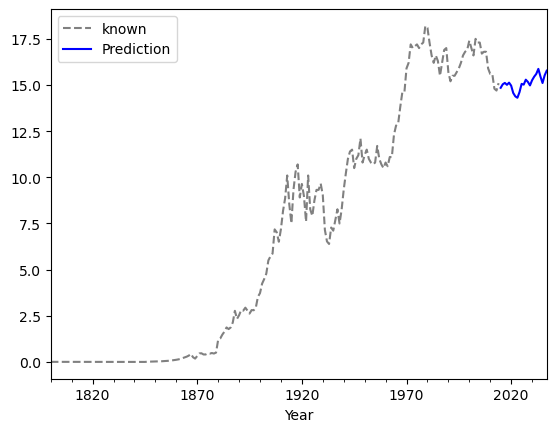

In [79]:
df['CO2'].plot(style='--', color='gray', legend=True, label='known')
double_exp_pred.plot(color='b',legend=True, label='Prediction')
plt.show()

In [81]:
import pickle

In [87]:
pickle.dump(ar,open('rider_sarimax.pkl','wb'))